In [1]:
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

In [2]:
# Get the supply data

# change the path here to run the code on your computer
df_supply = pd.read_excel("C://Users//kongl//Desktop//NYU Shanghai//Winter 2022//Optimization Modeling//Data & Excel Files/JuiceBlending_Data.xlsx", sheet_name = "Supply Information", header = 2)
df_supply.rename(columns={' (1000 Gallons)': 'Qty Available', 'per 1000 Gallons': 'Price',  'per 1000 Gallons.1': 'Shipping Cost'}, inplace = True)

In [3]:
# Get the historical juice data

# change the path here to run the code on your computer
df_ratio = pd.read_excel("C://Users//kongl//Desktop//NYU Shanghai//Winter 2022//Optimization Modeling//Data & Excel Files/JuiceBlending_Data.xlsx", header = 2, nrows = 11)
df_acid = pd.read_excel("C://Users//kongl//Desktop//NYU Shanghai//Winter 2022//Optimization Modeling//Data & Excel Files/JuiceBlending_Data.xlsx", header = 16, nrows = 11)
df_ast = pd.read_excel("C://Users//kongl//Desktop//NYU Shanghai//Winter 2022//Optimization Modeling//Data & Excel Files/JuiceBlending_Data.xlsx", header = 30, nrows = 11)
df_color = pd.read_excel("C://Users//kongl//Desktop//NYU Shanghai//Winter 2022//Optimization Modeling//Data & Excel Files/JuiceBlending_Data.xlsx", header = 44, nrows = 11)

In [4]:
df_ratio.drop(columns="Unnamed: 3", inplace = True)
df_acid.drop(columns="Unnamed: 3", inplace = True)
df_ast.drop(columns="Unnamed: 3", inplace = True)
df_color.drop(columns="Unnamed: 3", inplace = True)

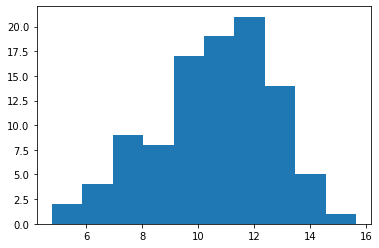

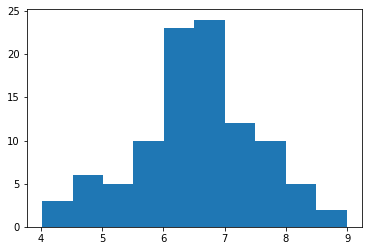

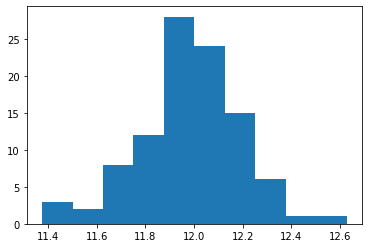

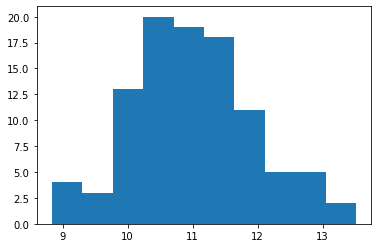

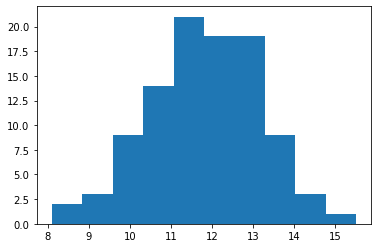

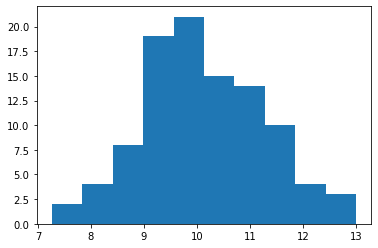

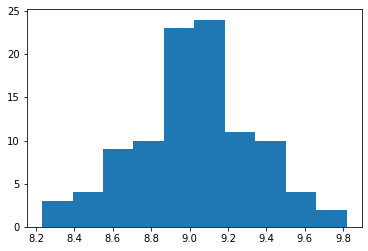

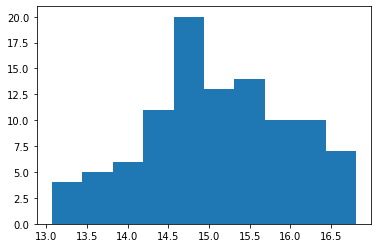

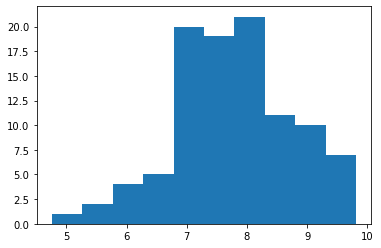

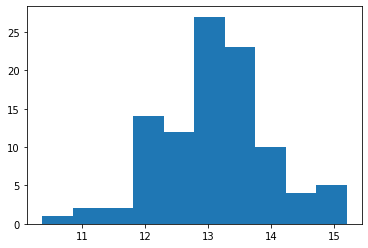

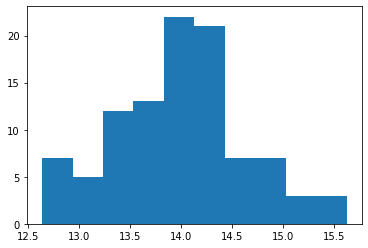

In [5]:
for i in range(df_ratio.shape[0]):
    plt.hist(df_ratio.iloc[i,3:])
    plt.show()

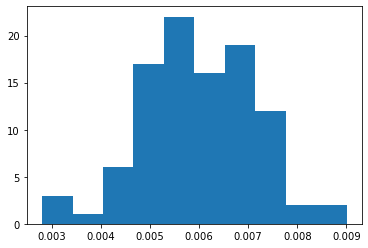

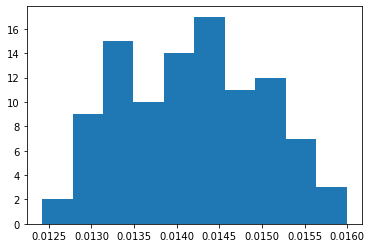

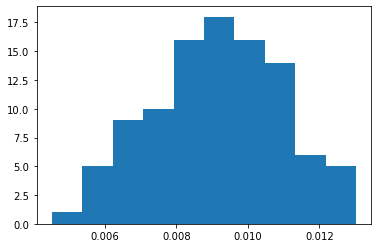

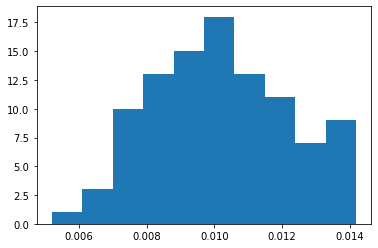

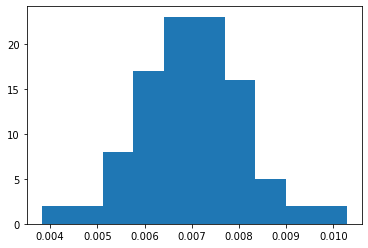

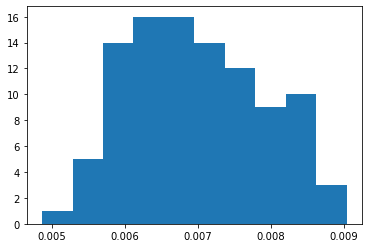

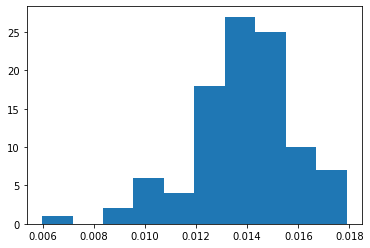

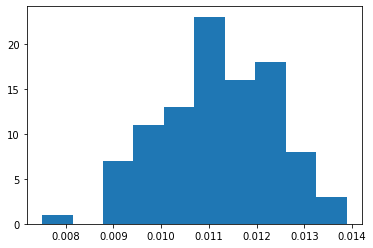

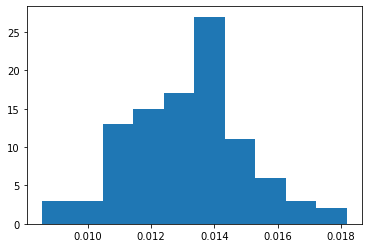

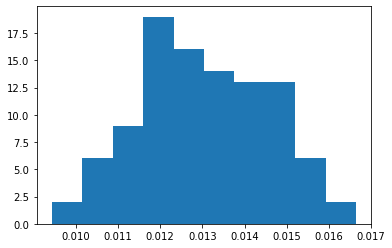

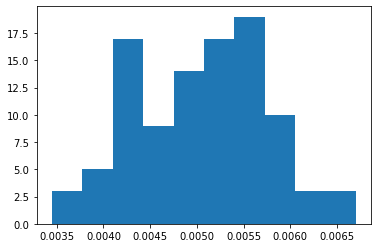

In [6]:
for i in range(df_acid.shape[0]):
    plt.hist(df_acid.iloc[i,3:])
    plt.show()

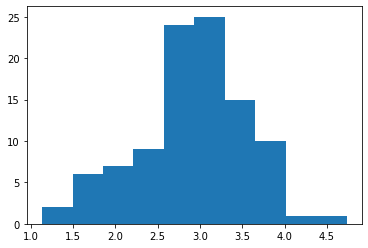

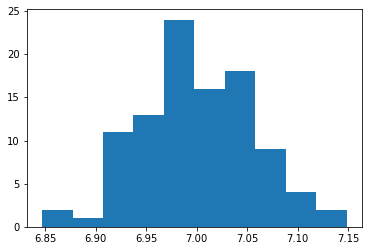

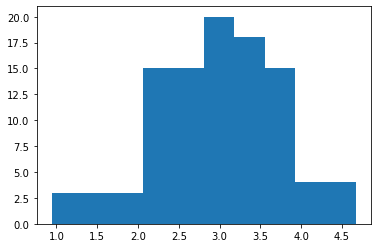

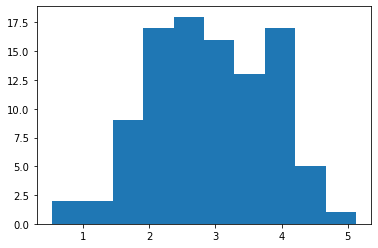

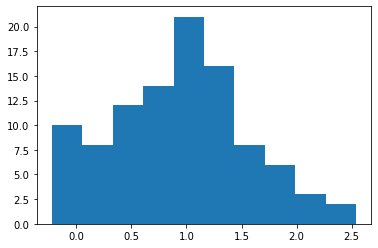

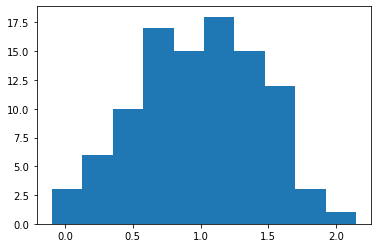

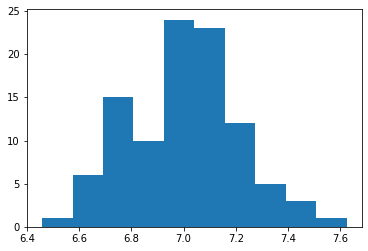

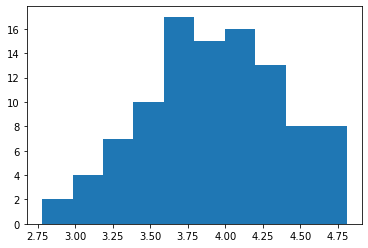

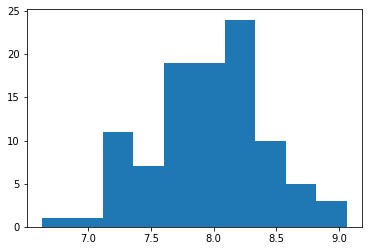

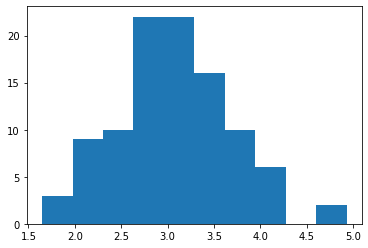

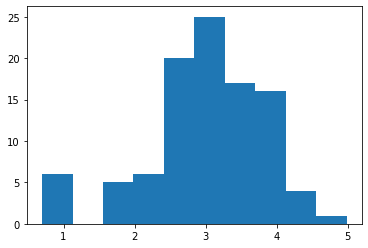

In [7]:
for i in range(df_ast.shape[0]):
    plt.hist(df_ast.iloc[i,3:])
    plt.show()

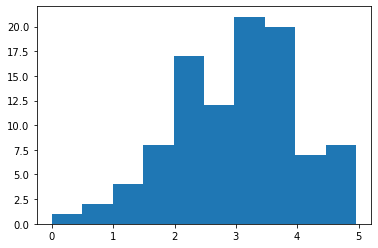

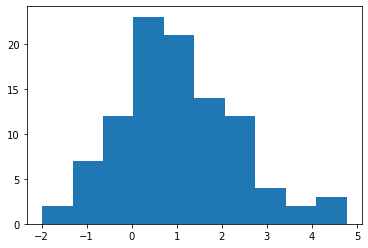

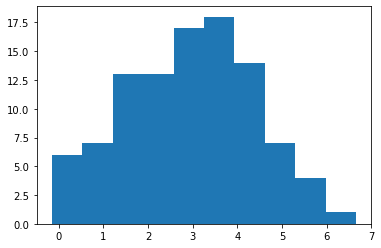

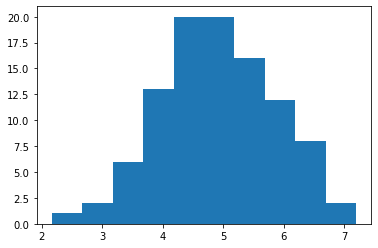

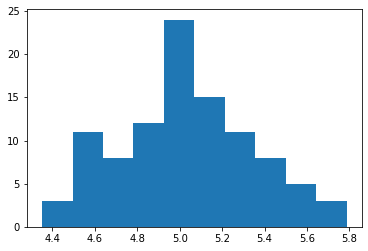

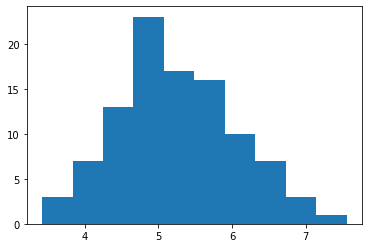

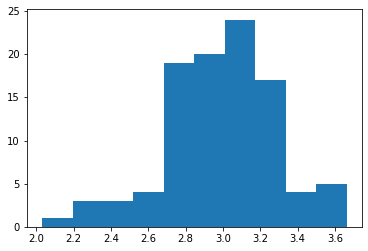

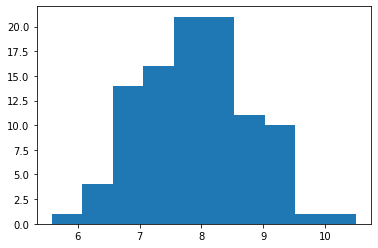

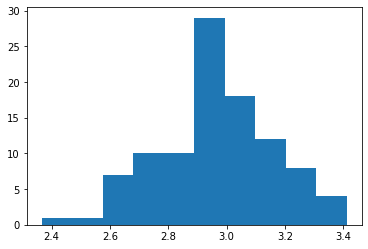

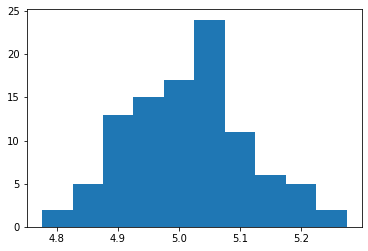

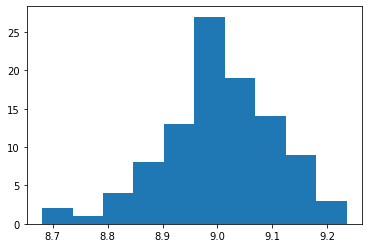

In [8]:
for i in range(df_color.shape[0]):
    plt.hist(df_color.iloc[i,3:])
    plt.show()

We can see that the distribution of all four parameters for all types of oranges could be considered as normal distributions. 

Let aggregate all parameter information into one dataframe.<br>
Aside of B/A ratio, we also calculate Brix.

In [9]:
df_quality = df_ratio.iloc[:,:3]
df_quality['mean_B/A_ratio'] = df_ratio.iloc[:,3:].apply(np.mean,axis=1)
df_quality['var_B/A_ratio'] = df_ratio.iloc[:,3:].apply(np.var,axis=1)
df_quality['mean_brix'] = (df_ratio.iloc[:,3:]*df_acid.iloc[:,3:]).apply(np.mean,axis=1)
df_quality['var_brix'] = (df_ratio.iloc[:,3:]*df_acid.iloc[:,3:]).apply(np.var,axis=1)
df_quality['mean_acid'] = df_acid.iloc[:,3:].apply(np.mean,axis=1)
df_quality['var_acid'] = df_acid.iloc[:,3:].apply(np.var,axis=1)
df_quality['mean_astringency'] = df_ast.iloc[:,3:].apply(np.mean,axis=1)
df_quality['var_astringency'] = df_ast.iloc[:,3:].apply(np.var,axis=1)
df_quality['mean_color'] = df_color.iloc[:,3:].apply(np.mean,axis=1)
df_quality['var_color'] = df_color.iloc[:,3:].apply(np.var,axis=1)

In [10]:
df_quality

,Supplier,Varietal,Region,mean_B/A_ratio,var_B/A_ratio,mean_brix,var_brix,mean_acid,var_acid,mean_astringency,var_astringency,mean_color,var_color
0,1,Hamlin,Brazil,10.566224,4.527604,0.063329,0.000334,0.005985,1.293830e-06,2.918313,0.443182,2.989712,0.981250
1,2,Mosambi,India,6.554385,0.977860,0.092971,0.000237,0.014172,6.664573e-07,7.001150,0.003071,1.033506,1.689223
2,3,Valencia,Florida,11.982141,0.044307,0.109327,0.000489,0.009121,3.319900e-06,2.991817,0.582337,2.922972,2.097732
3,4,Hamlin,California,10.996986,0.876279,0.112276,0.000634,0.010194,4.059953e-06,2.937240,0.836010,4.919592,0.926859
4,5,Gardner,Arizona,11.828215,1.775073,0.083284,0.000298,0.007021,1.224956e-06,0.942180,0.388804,5.024361,0.099349
5,6,Sunstar,Texas,10.138411,1.360862,0.070865,0.000156,0.006988,8.001644e-07,0.993960,0.207472,5.252154,0.686818
6,7,Jincheng,China,9.032141,0.092432,0.124535,0.000373,0.013777,4.106980e-06,6.997732,0.045012,2.993694,0.087322
7,8,Berna,Spain,15.091857,0.767003,0.169112,0.000431,0.011205,1.475896e-06,3.931403,0.199722,7.904481,0.786769
8,9,Verna,Mexico,7.755680,0.980188,0.102109,0.000392,0.013144,3.145343e-06,7.955996,0.206456,2.966521,0.038696
9,10,Biondo Commune,Egypt,13.109589,0.807233,0.170825,0.000615,0.013010,2.242802e-06,3.067081,0.379537,5.015766,0.009633


In [11]:
df_quality.to_csv("juice_quality.csv", index = False)

Now we get a dataframe containing the distribution data of all quality parameters for all suppliers.

Next, we can start constructing the optimizer.<br>
Also, we solve the optimizer for every time we added more constraints, just to see how adding more constraints affect the minimal cost.

In [12]:
Month = range(3)
Supplier = range(len(df_supply['Supplier']))
Qty = list(df_supply['Qty Available'])
CoG = [round(cost,2) for cost in df_supply['Price']]
CoS = list(df_supply['Shipping Cost'])
Demand = [900, 900, 1050]

In [13]:
model = ConcreteModel()
model.x = Var(Month, Supplier, within=NonNegativeReals)
#x_{ij} is the amount of juice procured from supplier j for every month i

In [14]:
model.obj = Objective(
    expr =  sum((CoG[j]+CoS[j])*model.x[i,j] for i in Month for j in Supplier), 
    sense = minimize)

In [15]:
def demand_rule(model,i):
    return   sum(model.x[i,j] for j in Supplier) == Demand[i]

model.demand_con = Constraint(Month, rule=demand_rule)

In [16]:
def supply_rule(model,j):
    return   sum(model.x[i,j] for i in Month) <= Qty[j]

model.supply_con = Constraint(Supplier, rule=supply_rule)

In [17]:
opt = SolverFactory('glpk').solve(model)
print('Procurement Plan:', value(model.obj))

Procurement Plan: 1608618.0


In [18]:
def florida_rule(model,i):
    return   model.x[i,2] >= 0.35*Demand[i]

model.florida_con = Constraint(Month, rule=florida_rule)

In [19]:
opt = SolverFactory('glpk').solve(model)
print('Procurement Plan:', value(model.obj))

Procurement Plan: 1791247.5


In [20]:
def color_lower_rule(model, i):
    return   sum(model.x[i,j]*df_quality['mean_color'][j] for j in Supplier)/Demand[i] >= 4.5

model.color_lower_con = Constraint(Month, rule=color_lower_rule)

In [21]:
def color_upper_rule(model, i):
    return   sum(model.x[i,j]*df_quality['mean_color'][j] for j in Supplier)/Demand[i] <= 5.6

model.color_upper_con = Constraint(Month, rule=color_upper_rule)

In [22]:
opt = SolverFactory('glpk').solve(model)
print('Procurement Plan:', value(model.obj))

Procurement Plan: 1980998.5951052858


In [23]:
def acid_lower_rule(model, i):
    return   sum(model.x[i,j]*df_quality['mean_acid'][j] for j in Supplier)/Demand[i] >= 0.0075

model.acid_lower_con = Constraint(Month, rule=acid_lower_rule)

In [24]:
def acid_upper_rule(model, i):
    return   sum(model.x[i,j]*df_quality['mean_acid'][j] for j in Supplier)/Demand[i] <= 0.01

model.acid_upper_con = Constraint(Month, rule=acid_upper_rule)

In [25]:
opt = SolverFactory('glpk').solve(model)
print('Procurement Plan:', value(model.obj))

Procurement Plan: 1981216.3992621724


In [26]:
def astringency_rule(model, i):
    return   sum(model.x[i,j]*df_quality['mean_astringency'][j] for j in Supplier)/Demand[i] <= 0.125

model.astringency_con = Constraint(Month, rule=astringency_rule)

In [27]:
opt = SolverFactory('glpk').solve(model)
print('Procurement Plan:', value(model.obj))

Procurement Plan: 1981216.3992621724


In [28]:
def ratio_lower_rule(model, i):
    return   (sum(model.x[i,j]*df_quality['mean_brix'][j] for j in Supplier)/Demand[i]) - 0.115*(sum(model.x[i,j]*df_quality['mean_acid'][j] for j in Supplier)/Demand[i]) >= 0

model.ratio_lower_con = Constraint(Month, rule=ratio_lower_rule)

In [29]:
def ratio_upper_rule(model, i):
    return   (sum(model.x[i,j]*df_quality['mean_brix'][j] for j in Supplier)/Demand[i]) - 0.125*(sum(model.x[i,j]*df_quality['mean_acid'][j] for j in Supplier)/Demand[i]) <= 0

model.ratio_upper_con = Constraint(Month, rule=ratio_upper_rule)

In [30]:
opt = SolverFactory('glpk').solve(model)
print('Procurement Plan:', value(model.obj))

Procurement Plan: 1981216.3992621724


In [31]:
df_procurement = df_quality.iloc[:,:3]
df_procurement['Jan'] = [value(model.x[0,j]) for j in Supplier]
df_procurement['Feb'] = [value(model.x[1,j]) for j in Supplier]
df_procurement['Mar'] = [value(model.x[2,j]) for j in Supplier]
df_procurement['Total_Supplier_Procurement'] = df_procurement['Jan']+df_procurement['Feb']+df_procurement['Mar']
total_line = ["Total",np.nan,np.nan,sum(df_procurement['Jan']),sum(df_procurement['Feb']),sum(df_procurement['Mar']),sum(df_procurement['Total_Supplier_Procurement'])]
df_procurement.loc[11] = total_line

In [32]:
df_procurement

,Supplier,Varietal,Region,Jan,Feb,Mar,Total_Supplier_Procurement
0,1,Hamlin,Brazil,0.000000,0.000000,0.000000,0.000000
1,2,Mosambi,India,0.000000,42.999112,0.000000,42.999112
2,3,Valencia,Florida,315.000000,315.000000,367.500000,997.500000
3,4,Hamlin,California,0.000000,0.000000,130.243957,130.243957
4,5,Gardner,Arizona,0.000000,0.000000,0.000000,0.000000
5,6,Sunstar,Texas,0.000000,195.237719,119.762281,315.000000
6,7,Jincheng,China,77.256931,0.000000,0.000000,77.256931
7,8,Berna,Spain,43.264984,208.735016,0.000000,252.000000
8,9,Verna,Mexico,256.202154,138.028153,55.769693,450.000000
9,10,Biondo Commune,Egypt,19.988703,0.000000,295.011297,315.000000


The optimized solution is listed above.<br>
The minimum cost we can get is $1981216.

Since color is the least important parameter for juice quality, we considered unleashing the color constraint for further cost reduction.<br> 
After removing the color constraints, we got a minimum cost of $1827096, which is a 7.8\% reduction in our previous minimum cost. 

It's worth mentioning that the results we got from python and excel are different.<br>
Overall, it seems that python's output is more reliable.